# COMP47700 Speech and Audio PL3: Speech analysis and feature extraction
---
## Learning outcomes
This practical tutorial covers the following learning outcomes within the COMP47700 Speech and Audio module:
* Analyse speech and audio signals and features (**LO1**)
  * Carry out an analysis of speech wav files using spectrogram plots and varying key parameters like `offset`, `duration`, and `n_fft`.
* Articulate the characteristics of speech, speech production and speech understanding (**LO2**)
  * Compute the spectrum for speech signals and extract the frequency formants (F1 and F2) and the fundamental frequency (F0) using `librosa`.
* Describe the signal characteristics of speech and audio signals using appropriate terminology (**LO3**)
  * Visualise and explore the distribution of frequency formants (F1, F2)  and the fundamental frequency (F0) for different speech utterances.
* Create programmes to conduct experiments on speech and audio samples building on third software libraries (**LO6**)
  * Download and extract compressed datasets from an external source using Python libraries.
  * Setup and organise files for data analysis using `pandas` dataframes.

## Module topics
This practical tutorial builds on the following core topics:
* Speech production, characteristics of speech and structure of speech (Unit 3)
* How we hear, speech auditory perception (Unit 4)

## Why is this important?
After gaining familiarity with basic tools in Python to read, manipulate and generate audio and speech digital signals, this practical tutorial explores speech signals characteristics and speech production. A solid understanding of these concepts is foundational for developing effective and accurate applications in Python, particularly in the fields of speech processing, natural language processing, machine learning, and audio signal processing.

## Structure of this tutorial
This practical tutorial contains different sections:
* **Live coding:** Basic theory, demos and coding examples presented by the lecturer on site (unmarked)
* **Student activity:** Familiarisation and coding exercises to be completed by the students and followed by a short discussion on site (unmarked)



*********** Highlight **********
* **Assignment:** Three (3) take home problem/coding questions to be completed by the students and due in two (2) weeks from the day the practical tutorial is given. Assignment questions represent fifteen (15) mark points.

## Setup notes
We will be using Google Colabs for our labs but if you wish to run speech and audio projects locally (not recommended) you will need a manage your own Python environment setup with a number of important packages.

Some important libraries for this practical tutorial are:

* [numpy](https://numpy.org) is the fundamental package for scientific computing with Python. From a signal processing perspective it allow us to represent continuous signals as discrete digitally sampled time series.
* [matplotlib](https://matplotlib.org) is a plotting and data visualisation library. Pyplot is a Matplotlib module that allows MATLAB-like interface to the matplotlib library funtions. Practically speaking, this means that you can build up a figure plot step by step, e.g. create a figure, add axes, add data to plot, customise the title and axes labels and change to look of the figure.
* [librosa](librosa.github.io) is a Python package for music and audio processing. It allows handling audio files and provides tasks for spectral analysis, feature extraction, spectrogram visualization, etc.
* [fftpack](https://docs.scipy.org/doc/scipy/reference/fftpack.html) this package provides a set of functions for performing FFT operations on arrays in Python. The FFT is particularly useful for analyzing signals in the frequency domain, as it allows you to transform a time-domain signal into its frequency components.

---
### **Live coding:** Loading libraries and helper functions
Get our working environment ready and load helper functions.
1. Import the libraries (`fftpack, listdir`) and setup the notebook for magic plots.
2. Load the function `plotSpectrum` to help us plot the speech spectrum.

In [ ]:
#Imports and Magic
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io, os
from scipy import fftpack
from os import listdir
import IPython.display as ipd
from google.colab import files
import zipfile
%matplotlib inline

`plotSpectrum` is just a helper function to allow us to plot the spectrum with labelled axes with a set range.

In [ ]:

def plotSpectrum(freq,mag,fname):
    fig1, ax=plt.subplots(1)

    ax.plot(freq, mag, color='gray')
    plt.grid()
    plt.title(fname)
    plt.xlim((0,3000))
    plt.xlabel('Freq. (Hz)')
    plt.ylabel('Magnitude')
    plt.tight_layout()
    plt.savefig('plots/'+fname+'.png')

### **Live coding:** Downloading and extracting lab zip file from Github

**Notes:** You can inspect the extracted folder in the files section at the table of contents.

In [ ]:
# Download the zip file
!wget https://github.com/COMP47700-Speech-and-Audio/PL3-Speech-analysis-and-feature-extraction/raw/main/PL3_files.zip

--2025-02-26 16:00:41--  https://github.com/COMP47700-Speech-and-Audio/PL3-Speech-analysis-and-feature-extraction/raw/main/PL3_files.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/COMP47700-Speech-and-Audio/PL3-Speech-analysis-and-feature-extraction/main/PL3_files.zip [following]
--2025-02-26 16:00:41--  https://raw.githubusercontent.com/COMP47700-Speech-and-Audio/PL3-Speech-analysis-and-feature-extraction/main/PL3_files.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1073400 (1.0M) [application/zip]
Saving to: ‘PL3_files.zip’

PL3_files.zip       100%[===================>]   1.02M  --.

In [ ]:
import zipfile

zipname = 'PL3_files.zip'
# Extract the zip file
with zipfile.ZipFile(zipname, 'r') as zip_ref:
    zip_ref.extractall()  # Extract all files to the current directory

In [ ]:
%cd /content/PL3_files/

/content/PL3_files


### **Live coding:** List files and setup dataframe
1. Load list of wav files for analysis (`listdir`)
2. Parse out word names and create dataframe columns (`split`)

In [ ]:
basedir='./phonemes/'
phonemefilenames=listdir(basedir)
phonemenames=[]
formants=[[],[]]
phonemefilenames = [x for x in phonemefilenames if x.__contains__('.wav')] # remove non-wavfiles from list

# parse out the word names from the files by getting the text between the - and the .wav extn
phonemenames = [name.split('-')[-1].split('.')[0] for name in phonemefilenames]
speakerid = [name.split('-')[0].split('.')[0] for name in phonemefilenames]
dfformants=pd.DataFrame(columns=['speaker','word','f1','f2'])
dfformants['speaker']=speakerid
dfformants['word']=phonemenames

### **Live coding:** Data inspection
Before we do anything let's sanity check the data by looking at it and listening to it.
1. Load the wav files changing the `offset` and `duration` parameters (`librosa.load`)
2. Plot the corresponding spectrogram (`librosa.display.specshow`)
3. Instantiate playback widgets for playing the audio files.
**Note:** `offset`, start reading after this time (in seconds). `duration`, only loads up to this much audio (in seconds). `n_fft`, length of the windowed signal after padding with zeros. Default value is `n_fft = 2048` (well suited for music signals), for speech processing common value is `n_fft = 512`.

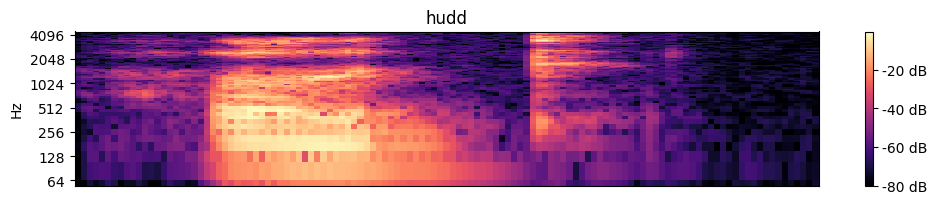

In [ ]:
fileidx = 1
x_1, sr = librosa.load(basedir+phonemefilenames[fileidx],offset=.1, duration=.7)
plt.figure(figsize=(12, 2))
D1 = librosa.amplitude_to_db(np.abs(librosa.stft(x_1,n_fft=512)),  ref=np.max)
librosa.display.specshow(D1, y_axis='log')
plt.title(phonemenames[fileidx])
plt.ylim(50,4500)
plt.colorbar(format='%+2.0f dB')

ipd.Audio(x_1, rate=sr)

### **Student activity #1:** Spectrogram representation
* Load the wav files corresponding to the words **had, head, hid, hood,** and **whod** setting the `offset` and `duration` to 0.1 and 0.6 respectively.
* Adapt the code above to iteratively plot the spectrogram representations for the loaded words. Set the `n_fft` parameter to 256.
* Instantiate playback widgets for playing the audio files.

**Note:** To iteratively display playback widgets use the `IPython.display` method (e.g., `ipd.display(ipd.Audio(signal, rate))`).

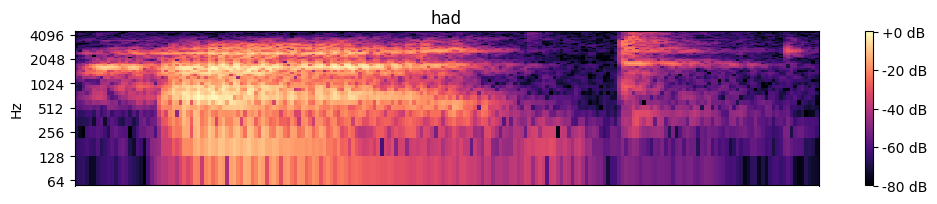

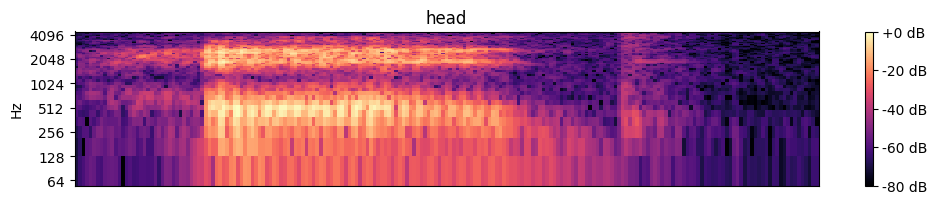

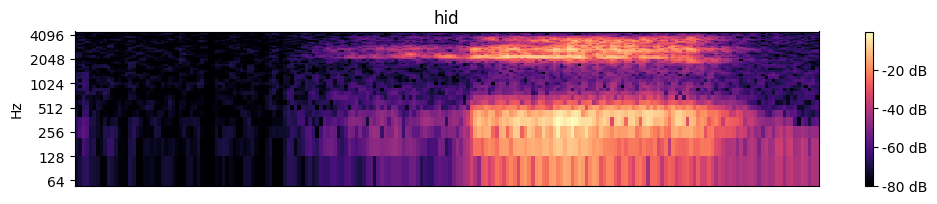

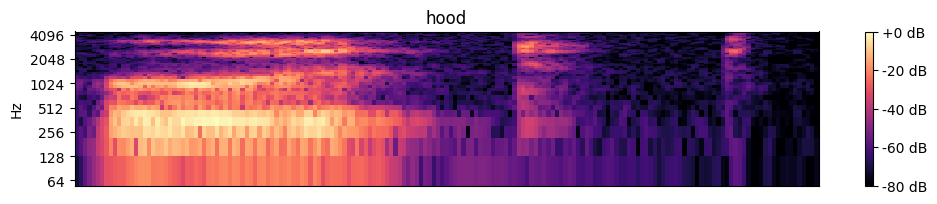

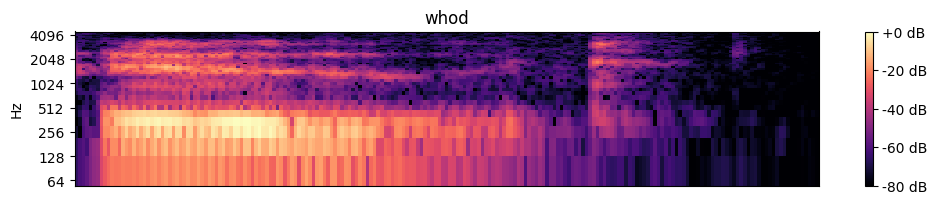

In [ ]:
###############################
## Student activity solution #1
###############################

#for fileidx in [1,5]:
for phonemes in ['had','head','hid','hood','whod']:
  x_1, sr = librosa.load(basedir+'453353-'+phonemes+'.wav',offset=.1, duration=.6)
  plt.figure(figsize=(12, 2))
  D1 = librosa.amplitude_to_db(np.abs(librosa.stft(x_1,n_fft=256)),  ref=np.max)
  librosa.display.specshow(D1, y_axis='log')
  plt.title(phonemes)
  plt.ylim(50,4500)
  plt.colorbar(format='%+2.0f dB')
  # Playback
  ipd.display(ipd.Audio(x_1, rate=sr))


### **Live coding:** Extracting F1, F2
First we will create a new folder named **plots** using the `os.mkdir` method and the `try except` block for error handling.

In [ ]:
try:
    os.mkdir('plots')
except OSError:
    print('plots directory already exists')

1. We will read the wav file for the word **"had"**. We do not need to process the entire file. All files start with a short silence and duration of 0.5 s will suffice.
2. We will use `fftpack.fft` to get the frequency spectrum components for the files. `fftpack.fftfreq` will give us the frequencies associated with the intensities.
3. We will use `plotSpectum` to save the plots into our **plots** sub directory.

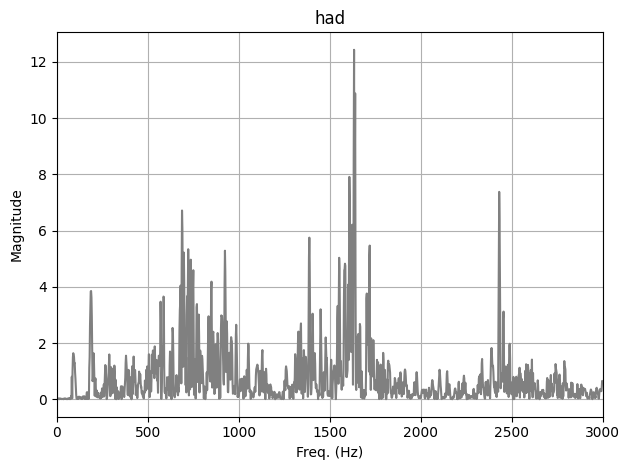

In [ ]:
# Load file and organise spectrum components
name = 'had'
fname = '453353-had.wav'
x_1, fs = librosa.load(basedir+fname,duration=0.5)

X = fftpack.fft(x_1) #get the FFT intensities
freq=fftpack.fftfreq(len(x_1))*fs # get the corresponding frequencies
freqidx=int(len(freq)/2) # ignore the negitive mirror image of fft
freq=freq[1:freqidx] # get the freqs
mag=np.abs(X.real) # that the real absolute magnitudes
mag=mag[1:freqidx] # for the positive freqs
plotSpectrum(freq, mag, name)

4. We will use the librosa peakfinder `librosa.util.peak_pick` method to find the peaks in the signal.
5. Using the peak indexes we will create lists of the frequencies and magnitudes corresponding to those peaks. We will use them to populate a data frame.

In [ ]:
#use librosa peak_pick utility to find peaks
indexes = librosa.util.peak_pick(mag, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.1, wait=1)

peaks=[freq[indexes],mag[indexes]]

peaksdf=pd.DataFrame(peaks).T
peaksdf.columns=['freq','mag']
peaksdf

freq       mag
0      90.0  1.637866
1     166.0  0.253844
2     188.0  3.849643
3     202.0  1.634118
4     212.0  0.739918
..      ...       ...
172  3110.0  0.426377
173  3120.0  0.798275
174  3148.0  0.508839
175  3314.0  0.197464
176  3396.0  0.202230

[177 rows x 2 columns]

6. Using the rough approximation from the graph we introduced in the lecture, we make the assumption that $250 \leq F1 \leq 650$ and $650 \leq F2 \leq 2600$.
6. Using the `between` and `idxmax()` methods we will find the F1 and F2 values.
7. We will print the word and their corresponding F1 and F2 values.

Word: had 
 F1: 586.00 
 F2: 1634.00


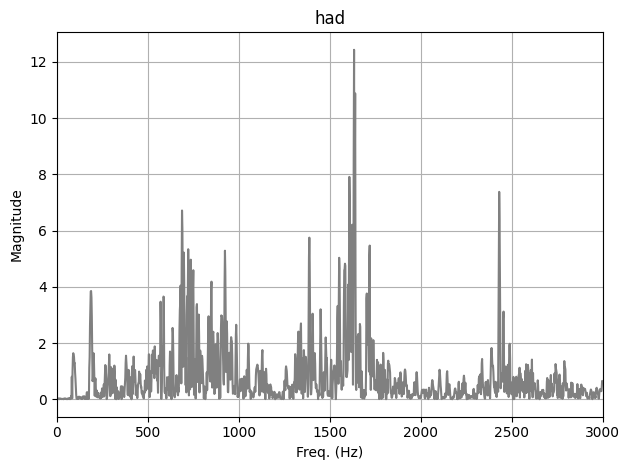

In [ ]:
# find the first and second formant:
# first formant is max peak between ~ 250 and  650 Hz
# second formant is max peak between ~ 650 and 2600 Hz

fmin = 250
f1max=650
f2max=3000
peaksdf=pd.DataFrame(peaks).T # Create a dataframe and transpose rows to cols
peaksdf.columns=['freq','mag']    # label them
f1peaks=peaksdf[peaksdf.freq.between(fmin,f1max)] #get the frequencies in formant 1 freq range
f1=f1peaks['freq'][f1peaks['mag'].idxmax()] #get the freq for the index of the max amp in this range

f2peaks=peaksdf[peaksdf.freq.between(f1max,f2max)] #get the frequencies in formant 1 freq range
f2=f2peaks['freq'][f2peaks['mag'].idxmax()] #get the freq for the index of the max amp in this range

print('Word: had \n F1: {:.2f} \n F2: {:.2f}'.format(f1,f2))
plotSpectrum(freq, mag, name)

### **Student activity #2:** Computing speech spectrum and extracting F1 and F2 for multiple files
* Use the **phonemefilenames** list and the method `enumerate` to iteratively load all files in the list. Set the `offset` and `duration` to 0.1 and 0.6 respectively.
* Adapt the code above to iteratively plot the spectrum and compute F1 and F2 values for all files in the **phonemefilenames** list.
* Insert F1 and F2 values into the dataframe we created earlier (**dfformants**) and save that to a csv file (**speakerformants.csv**).

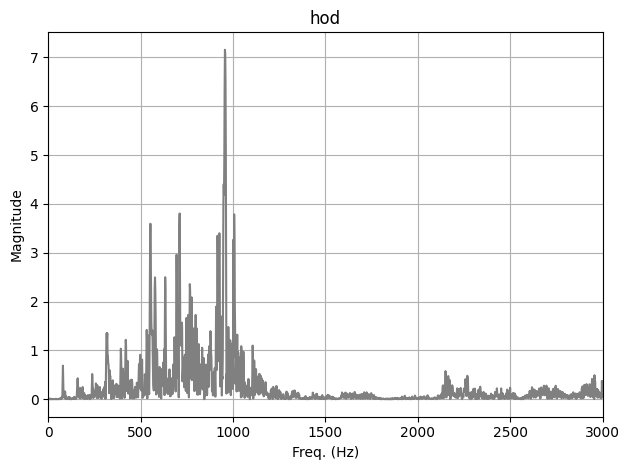

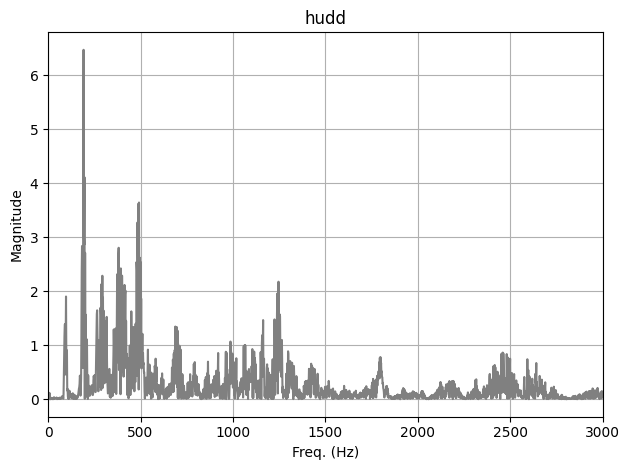

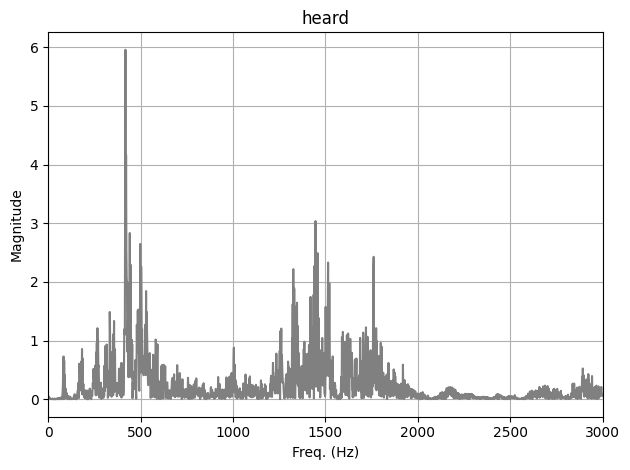

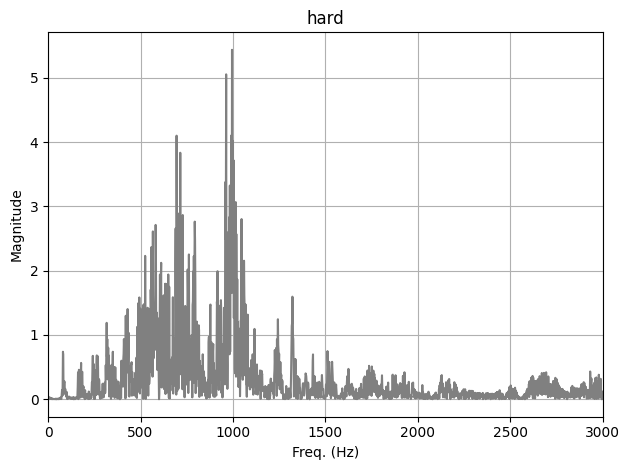

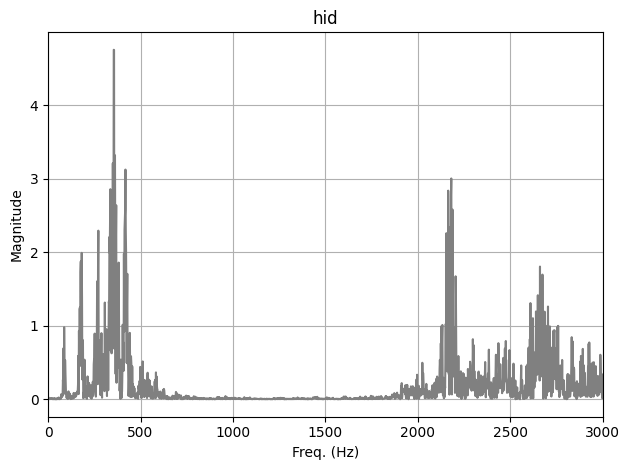

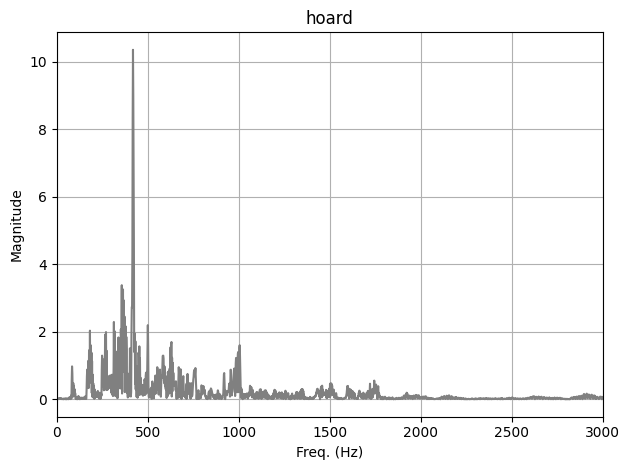

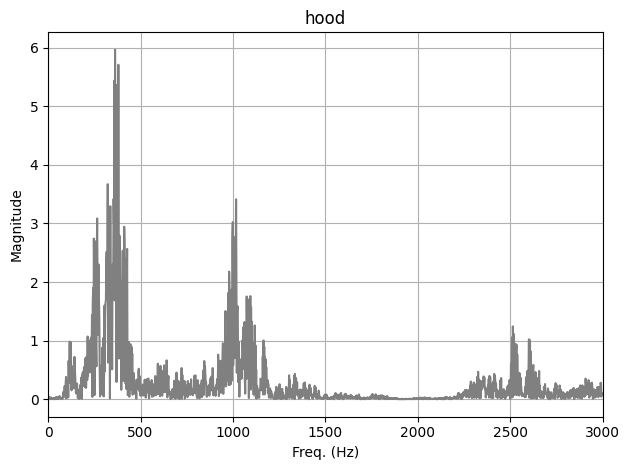

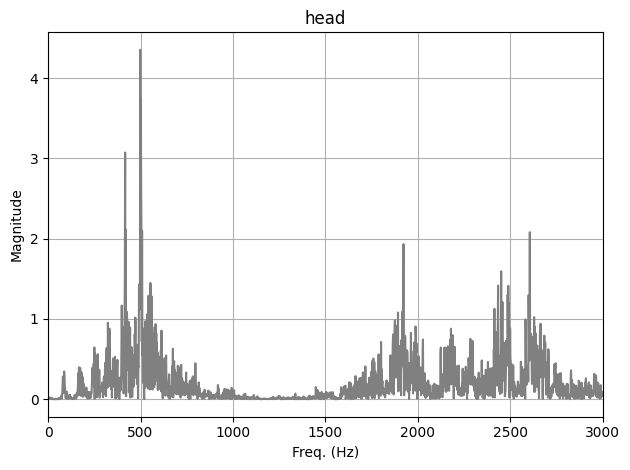

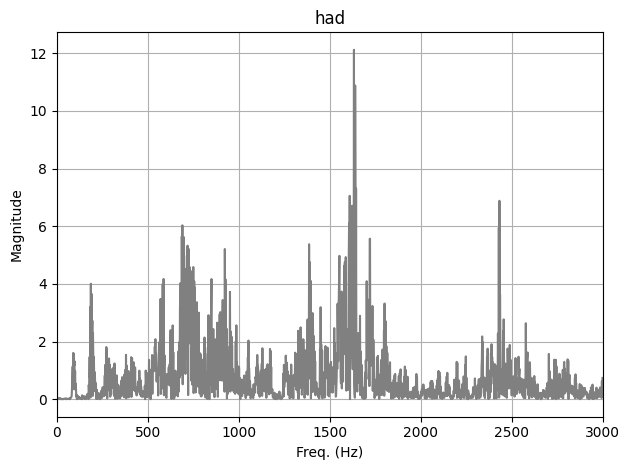

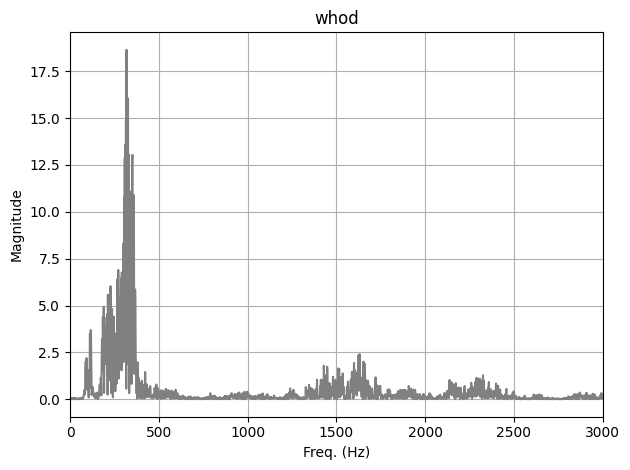

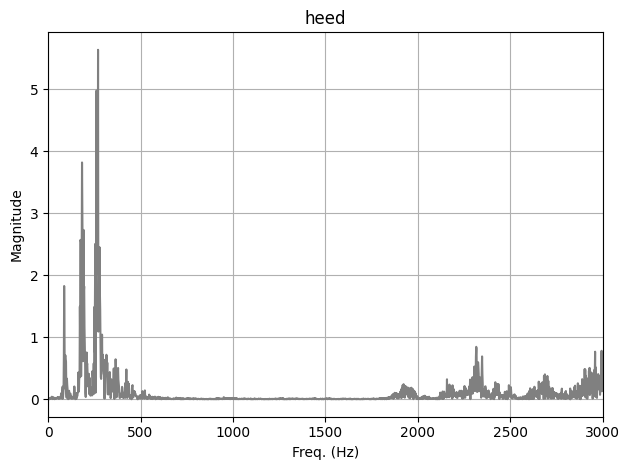

In [ ]:
###############################
## Student activity solution #2
###############################

formants=[[],[]]

for idx,fname in enumerate(phonemefilenames):
      x_1, fs = librosa.load(basedir+fname,duration=0.6, offset=.1)
      X = fftpack.fft(x_1) #get the FFT intensities
      freq=fftpack.fftfreq(len(x_1))*fs # get the corresponding frequencies
      freqidx=int(len(freq)/2) # ignore the negitive mirror image of fft
      freq=freq[1:freqidx] # get the freqs
      mag=np.abs(X.real) # that the real absolute magnitudes
      mag=mag[1:freqidx] # for the positive freqs

      # Plot spectrum
      plotSpectrum(freq, mag, phonemenames[idx])

      #use librosa pick utility to find peaks
      indexes = librosa.util.peak_pick(mag, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.1, wait=1)
      peaks=[freq[indexes],mag[indexes]]
      peaksdf=pd.DataFrame(peaks).T
      peaksdf.columns=['freq','mag']

      # find the first and second formant:
      # first formant is max peak between ~ 250 and  650 Hz
      # second formant is max peak between ~ 650 and 2600 Hz

      fmin = 250
      f1max=650
      f2max=3000
      peaksdf=pd.DataFrame(peaks).T # Create a dataframe and transpose rows to cols
      peaksdf.columns=['freq','mag']    # label them
      f1peaks=peaksdf[peaksdf.freq.between(fmin,f1max)] #get the frequencies in formant 1 freq range
      f1=f1peaks['freq'][f1peaks['mag'].idxmax()] #get the freq for the index of the max amp in this range

      f2peaks=peaksdf[peaksdf.freq.between(f1max,f2max)] #get the frequencies in formant 1 freq range
      f2=f2peaks['freq'][f2peaks['mag'].idxmax()] #get the freq for the index of the max amp in this range

      formants[0].append(f1)
      formants[1].append(f2)


dfformants['f1']=formants[0]
dfformants['f2']=formants[1]


dfformants.to_csv('speakerformants.csv')

### **Live coding:** Vowel F1/F2 visualization
Using the extracted F1 and F2 values we will generate a scatter plot for all words in the **dfformants** data frame.
1. Using the `scatter` method we will plot **-(F2-F1)** vs **F1** for all words.
2. We will annotate the names for each word in the scatter plot.
3. We will save the figure in the **plots** sub diresctory as **vowelf1f2male453353.png**
4. We will print the **dfformants** data frame to inspect our plot and the F1 and F2 values.

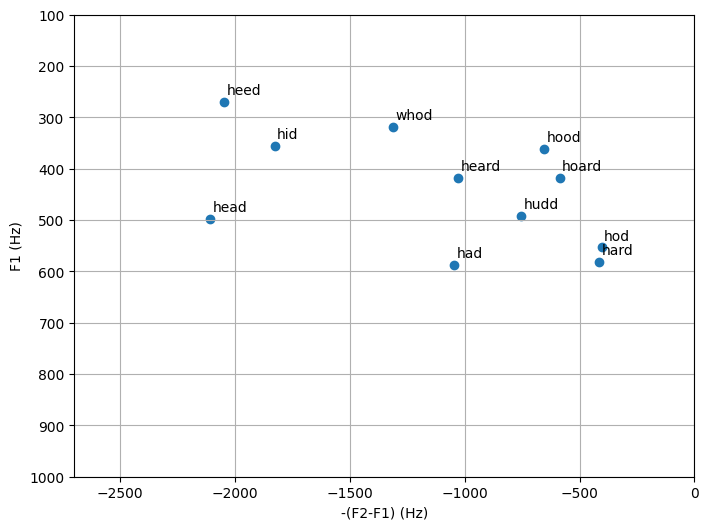

In [ ]:
fig1=plt.figure(figsize=(8, 6))
ax2=fig1.add_subplot(111)
plt.scatter(-(dfformants['f2']-dfformants['f1']),dfformants['f1'])

for idx, phonemename in enumerate(phonemenames):
    ax2.annotate(phonemename,  xy=(-(formants[1][idx]-formants[0][idx])+10,formants[0][idx]-15))

plt.xlim((-2700, 0))
plt.ylim((1000, 100))
plt.grid(axis='both')
plt.xlabel('-(F2-F1) (Hz)')
plt.ylabel('F1 (Hz)')

plt.savefig('plots/vowelf1f2male453353.png')
plt.show()

In [ ]:
dfformants

speaker   word          f1           f2
0   453353    hod  553.333333   956.666667
1   453353   hudd  491.666667  1246.666667
2   453353  heard  418.333333  1446.666667
3   453353   hard  581.666667   995.000000
4   453353    hid  355.000000  2181.666667
5   453353  hoard  418.333333  1005.000000
6   453353   hood  362.091709  1017.022613
7   453353   head  498.333333  2606.666667
8   453353    had  586.666667  1633.333333
9   453353   whod  318.333333  1631.666667
10  453353   heed  270.000000  2316.666667

### **Live coding:** Computing the Fundamental Frequency (F0)

* Describes the tone of the voice (roughly in the range 80 to 450 Hz).
* Closely related to pitch, F0 describes the actual physical phenomenon, whereas pitch describes how our ears and brains interpret the signal.
* `librosa` provides the `pyin` function to compute F0 using a modified version of the YIN algorithm.

Reference:
* [Introduction to Speech Processing](https://speechprocessingbook.aalto.fi/)
* [Mauch, Matthias, and Simon Dixon. “pYIN: A fundamental frequency estimator using probabilistic threshold distributions.” 2014 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP). IEEE, 2014.](https://www.eecs.qmul.ac.uk/~simond/pub/2014/MauchDixon-PYIN-ICASSP2014.pdf)

<ipython-input-16-5449e1cf51fe>:2: DeprecationWarning: `scipy.signal.waveforms.nan` is deprecated along with the `scipy.signal.waveforms` namespace. `scipy.signal.waveforms.nan` will be removed in SciPy 1.14.0, and the `scipy.signal.waveforms` namespace will be removed in SciPy 2.0.0.
  from scipy.signal.waveforms import nan


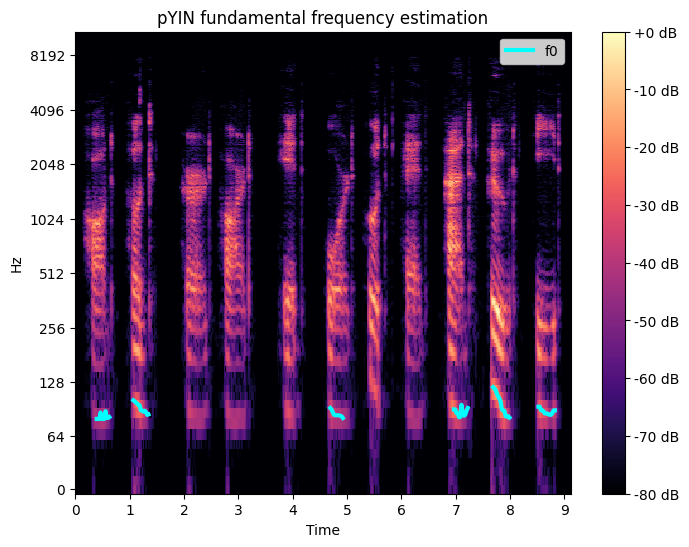

In [ ]:
#from pandas.core.internals.concat import concat_arrays
from scipy.signal.waveforms import nan
import matplotlib.pyplot as plt
import numpy as np
import librosa.display
import scipy

#create a single sample array containing all the words
concat_words_y=np.array([])
for idx,fname in enumerate(phonemefilenames):
    y, sr = librosa.load(basedir+fname)
    concat_words_y=np.append(concat_words_y,y)
y=concat_words_y

#run pyin to estimate pitch/f0

f0, voiced_flag, voiced_probs = librosa.pyin(y, sr=sr,
                                          fmin=80,
                                          fmax=450)
# Pitch range for humans is 70-900 Hz (Heylen et al., 2002)

times = librosa.times_like(f0)

# plot the spectro and overlay the pitch estimate

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots(figsize=(8, 6))
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

Compute the average f0 (pitch) from the non-nan pitch estimates.

In [ ]:
f0nonan=f0[np.logical_not(np.isnan(f0))]
f0mean=np.mean(f0nonan)
print(f0mean)

89.07844794175004


# Assignment 3

### Question 1

**Analyse speech and audio signals and features.**

Record yourself speaking each of the following 11 words clearly and distinctly.

 - hid
 - hood
 - head
 - whod
 - heed
 - hudd
 - hod
 - had
 - heard
 - hard
 - hoard

Save each file in 16-bit mono format with a filename following this format: **452352-\<phonemename\>.wav.** using `452352` as your unique 6-digit speaker ID. Your wav files should look like this: `452352-hid.wav`, `452352-hood.wav`, etc. Create a folder `phonemes_student` and store the 11 wav files there. Upload this folder to your Colab environment.

**Note:** Remember to attach your `phonemes_student` folder as a zip file when you submit your assignment at Brightspace.

Create a Pandas dataframe with columns: `["speaker", "word", "F1", "F2"]`. Populate the dataframe for all the files in the three folders `phonemes`, `synthetic`, `phonemes_student`.

**Note:** Set the `offset` and `duration` to 0.1 and 0.6 respectively to calculate F1 and F2 values

Plot F1 vs -(F2-F1) for the three sets of words: 1) original set of words `phonemes`, 2) synthetic set of words `synthetic`, and 3) your own voice recordings `phonemes_student`. Set different colours for each speaker. Add a text annotation with the phoneme word (as done in PL3).

Compare the plotted points for each of the three sets of words highlighting the following aspects:
 - Do the points for the multiple utterances of the same word cluster together?
 - Do the points for synthetic utterances cluster together with natural utterances?
 - Does the original utterances clustered with yours?


In [ ]:
from google.colab import files
zipname = 'phonemes_student.zip'
uploaded = files.upload()

Saving phonemes_student.zip to phonemes_student.zip


In [ ]:
import zipfile
# Extract the zip file
with zipfile.ZipFile(zipname, 'r') as zip_ref:
  zip_ref.extractall()  # Extract all files to the current directory

In [ ]:
print(os.listdir())

['synthetic', 'phonemes_student', 'plots', '.DS_Store', 'phonemes', 'sample_audio_pitch.wav', 'speakerformants.csv', 'phonemes_student.zip', '__MACOSX']


   speaker   word          F1           F2
0   453353    hod  553.333333   956.666667
1   453353   hudd  491.666667  1246.666667
2   453353  heard  418.333333  1446.666667
3   453353   hard  581.666667   995.000000
4   453353    hid  355.000000  2181.666667
5   453353  hoard  418.333333  1005.000000
6   453353   hood  362.091709  1017.022613
7   453353   head  498.333333  2606.666667
8   453353    had  586.666667  1633.333333
9   453353   whod  318.333333  1631.666667
10  453353   heed  270.000000  2316.666667
11  451351   hard  368.578767   925.941781
12  451351    had  295.000000  1028.333333
13  451351   hood  502.951542  1340.484581
14  451351  heard  421.606119  1509.751434
15  451351    hid  465.909091  2336.363636
16  451351   hudd  561.054378   743.068675
17  451351   head  316.613114   823.636911
18  451351  hoard  514.290797   772.307875
19  451351   heed  380.612154  2511.255450
20  451351   whod  432.538931  1307.102297
21  451351    hod  591.838120  1029.383812
22  452352 

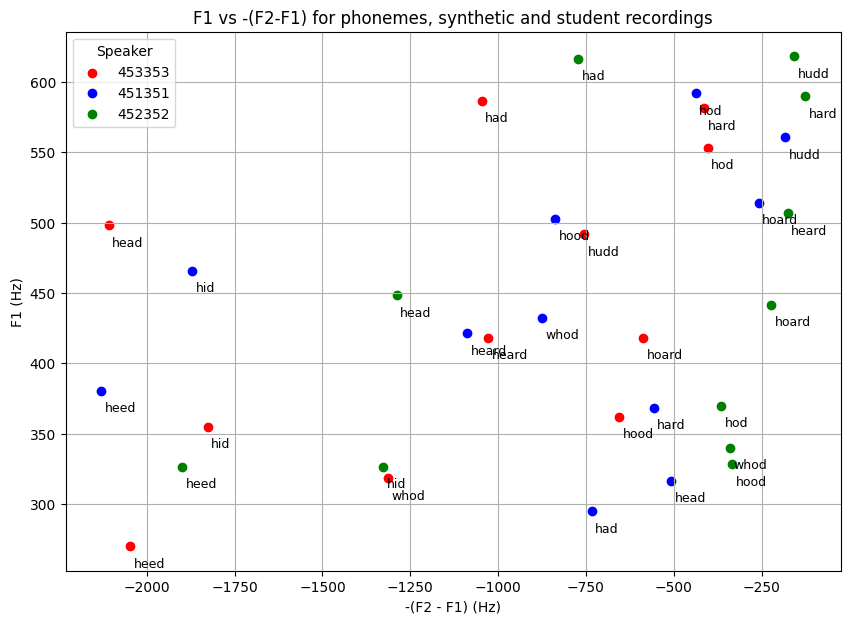

In [ ]:
# Define a helper function to process a folder and compute F1 and F2 for every wav file in that folder.
def compute_formants_for_folder(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    records = []
    for fname in files:
        parts = fname.split('-')
        speaker = parts[0]
        word = parts[1].split('.')[0]

        # Load wav file using offset and duration as specified
        try:
            signal, fs = librosa.load(os.path.join(folder_path, fname), offset=0.1, duration=0.6)
        except Exception as e:
            print(f"Failed to load {fname}: {e}")
            continue

        # Compute FFT and extract frequency spectrum
        X = fftpack.fft(signal)
        freqs = fftpack.fftfreq(len(signal)) * fs
        half_range = int(len(freqs)//2)
        freqs = freqs[1:half_range]
        mags = np.abs(X.real)[1:half_range]

        # Use peak picking to find the peaks
        indexes = librosa.util.peak_pick(mags, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.1, wait=1)
        if len(indexes) == 0:
            print(f"No peaks found for file {fname}")
            continue
        peaks = {'freq': freqs[indexes], 'mag': mags[indexes]}
        peaksdf = pd.DataFrame(peaks)

        # Define thresholds for formants
        fmin = 250 # 1) We use 250 Hz as lower threshold so we ignore the very low frequencies that usually aren't F1.
        f1max = 650 # 2) We pick 650 Hz as the upper bound of F1 because most adult vowels don't exceed this range for F1.
        f2max = 3000 # 3) We set 3000 Hz for F2's max since higher front vowels often reach up to around 3000 Hz.

        f1_peaks = peaksdf[peaksdf.freq.between(fmin, f1max)]
        if f1_peaks.empty:
            f1 = np.nan
        else:
            f1 = f1_peaks.loc[f1_peaks.mag.idxmax(), 'freq']

        f2_peaks = peaksdf[peaksdf.freq.between(f1max, f2max)]
        if f2_peaks.empty:
            f2 = np.nan
        else:
            f2 = f2_peaks.loc[f2_peaks.mag.idxmax(), 'freq']

        records.append({'speaker': speaker, 'word': word, 'F1': f1, 'F2': f2})
    return pd.DataFrame(records)

# Process each folder.
folder_phonemes = './phonemes/'
folder_synthetic = './synthetic/'
folder_student = './phonemes_student/'

df_phonemes = compute_formants_for_folder(folder_phonemes)
df_synthetic = compute_formants_for_folder(folder_synthetic)
df_student = compute_formants_for_folder(folder_student)

# Create a combined dataframe
df_combined = pd.concat([df_phonemes, df_synthetic, df_student], ignore_index=True)
print(df_combined)

# Plot F1 vs -(F2-F1) with different colors per speaker
speakers = df_combined['speaker'].unique()
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']
color_map = {sp: colors[i % len(colors)] for i, sp in enumerate(speakers)}

plt.figure(figsize=(10, 7))
for idx, row in df_combined.iterrows():
    if pd.notna(row['F1']) and pd.notna(row['F2']):
        x_val = -(row['F2'] - row['F1'])
        y_val = row['F1']
        plt.scatter(x_val, y_val, color=color_map[row['speaker']], label=row['speaker'] if row['speaker'] not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.text(x_val+10, y_val-15, row['word'], fontsize=9)
plt.xlabel("-(F2 - F1) (Hz)")
plt.ylabel("F1 (Hz)")
plt.title("F1 vs -(F2-F1) for phonemes, synthetic and student recordings")
plt.grid(True)
plt.legend(title="Speaker")
plt.show()

1. **Multiple utterances of the same word**  
   The points for the same word mostly group together on the plot. You can see “head” or “hid” each forming a little cluster, though sometimes each speaker shift the formants a bit, so they not in the exact same spot.

2. **Synthetic utterances vs. natural**  
   The synthetic tokens is pretty near the natural ones. They not exactly in the same place, but overall they overlap enough that we can say they are in the same region.

3. **Original utterances with yours**  
   Some of your words line up close to the original set, and some is slightly off. So, there is partial clustering—especially for vowels like “head” and “had”—but there’s small differences in the F1 or -(F2-F1) values for a few words.

### Question 2

**Articulate the characteristics of speech and speech production.**

As done in PL3, concatenate the words for all three sets. You should have three sets of words (`phonemes`, `synthetic`, and `phonemes_student`). Run `pyin` to estimate pitch/f0 for each set of words (speaker). Plot the spectro and overlay the pitch estimate. Compute the average pitch from the non-nan pitch estimates.


Processing Original recordings...


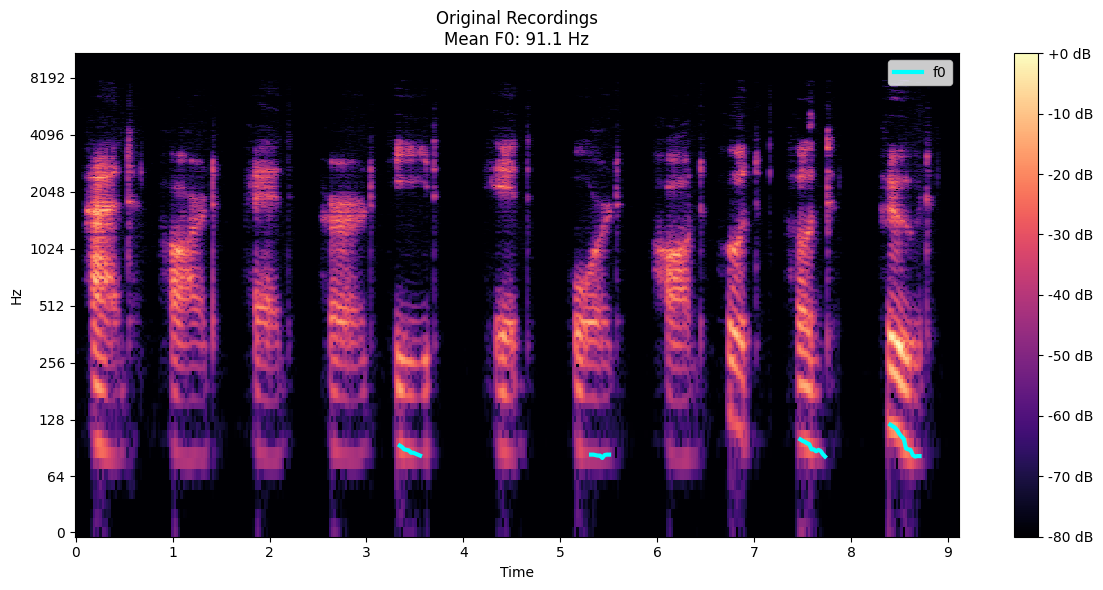

Average F0 for Original recordings: 91.1 Hz

Processing Synthetic recordings...


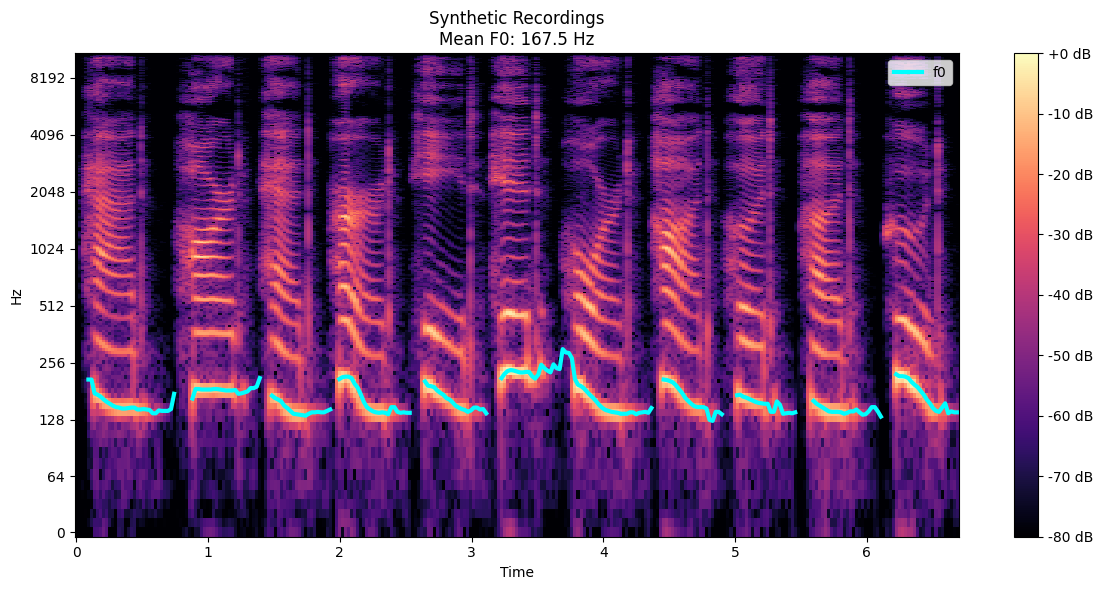

Average F0 for Synthetic recordings: 167.5 Hz

Processing Student recordings...


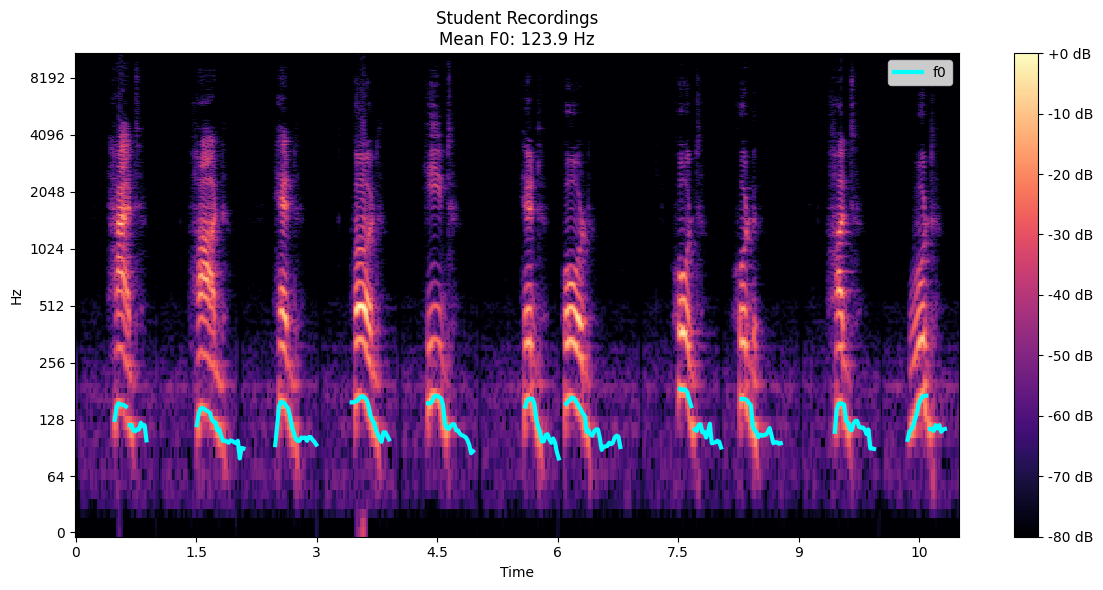

Average F0 for Student recordings: 123.9 Hz


In [ ]:
def concatenate_audio_from_folder(folder_path):
    concat_audio = np.array([])
    for fname in sorted(os.listdir(folder_path)):
        if fname.endswith('.wav'):
            y, sr = librosa.load(os.path.join(folder_path, fname))
            concat_audio = np.append(concat_audio, y)
    return concat_audio, sr

# Function to analyze pitch using pYIN and plot results
def analyze_and_plot_pitch(audio, sr, title):
    # Compute pYIN pitch estimation
    f0, voiced_flag, voiced_probs = librosa.pyin(audio,
                                                sr=sr,
                                                fmin=80,
                                                fmax=450)

    # Calculate average F0 (excluding nan values)
    f0_mean = np.nanmean(f0)

    # Create time axis
    times = librosa.times_like(f0)

    # Compute spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
    ax.set(title=f'{title}\nMean F0: {f0_mean:.1f} Hz')
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    return f0_mean

# Process each folder
folders = {
    'Original': './phonemes/',
    'Synthetic': './synthetic/',
    'Student': './phonemes_student/'
}

# Analyze each set
for name, folder in folders.items():
    try:
        print(f"\nProcessing {name} recordings...")
        audio, sr = concatenate_audio_from_folder(folder)
        if len(audio) > 0:
            mean_f0 = analyze_and_plot_pitch(audio, sr, f"{name} Recordings")
            print(f"Average F0 for {name} recordings: {mean_f0:.1f} Hz")
        else:
            print(f"No audio files found in {folder}")
    except Exception as e:
        print(f"Error processing {name} recordings: {str(e)}")

### Question 3

**Explore different methods to estimate the characteristics of speech.**

Explore a new algorithm 'CREPE' for f0 estimation. Run `CREPE` to estimate pitch/f0 for each of the three (`phonemes`, `synthetic`, and `phonemes_student`) set of words (speaker). Plot the spectro and overlay the pitch estimate. Compute the average pitch from the non-nan pitch estimates.

**Note:** Here is the github repo for CREPE.
https://github.com/marl/crepe


(a) Explore the return values of crepe algorithm and explain the meaning of each return value.

(b) Compare and contrast the results produced by the two algorithms `pyin` and `CREPE`, highlighting which algorithm produces more accurate pitch estimation and explaining your rationale.

In [ ]:
!pip install crepe

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.9 MB/s eta 0:00:00
  Created wheel for crepe: filename=crepe-0.0.16-py3-none-any.whl size=134848676 sha256=309e9dfbbd85bf9052c1ea05b91f54762474576b9cdd29ef3ac3f4ad4282d253
  Stored in directory: /root/.cache/pip/wheels/fb/54/e2/e2d6bc065d4bbd6920e243682536fe85bb3b33daacbbeb9672
Successfully built crepe


In [ ]:
import crepe

Hey, so I've been looking into this CREPE algorithm and comparing it with PYIN for pitch estimation. Here's what I found out:

(a) CREPE Return Values Explanation:
I read this paper[[1]](https://www.justinsalamon.com/uploads/4/3/9/4/4394963/kim_crepe_icassp_2018.pdf) and it says CREPE gives back a few things:

- Time: It's like, when each bit of sound happened
- Frequency: This is the pitch it thinks it heard (in Hz)
- Confidence: A number from 0 to 1 that shows how sure it is about the pitch
- Activation: Some complicated output from the neural network that helps figure out the confidence

These values help us know where and how sure CREPE was about the pitches it found.

(b) Comparing PYIN and CREPE:
So, I found out that PYIN is pretty good for simple sounds without much noise. It uses some time-based method to guess the pitch. But CREPE is different - it uses this deep learning stuff which makes it better at handling tricky situations[[2]](https://arxiv.org/pdf/2206.14357.pdf).

I read this other paper[[3]](https://www.isca-archive.org/interspeech_2021/schroter21_interspeech.pdf) and it said CREPE is usually more accurate because it's been trained on tons of data. This means it can handle complex audio better than PYIN.

From what I understand, CREPE is like, more robust especially when you've got noisy audio or lots of sounds mixed together. It's not just guessing, but actually understanding different pitches better.

So yeah, both PYIN and CREPE are useful, but CREPE seems to be the winner when it comes to dealing with tough audio situations.



Processing Original recordings using CREPE...
29/29 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step


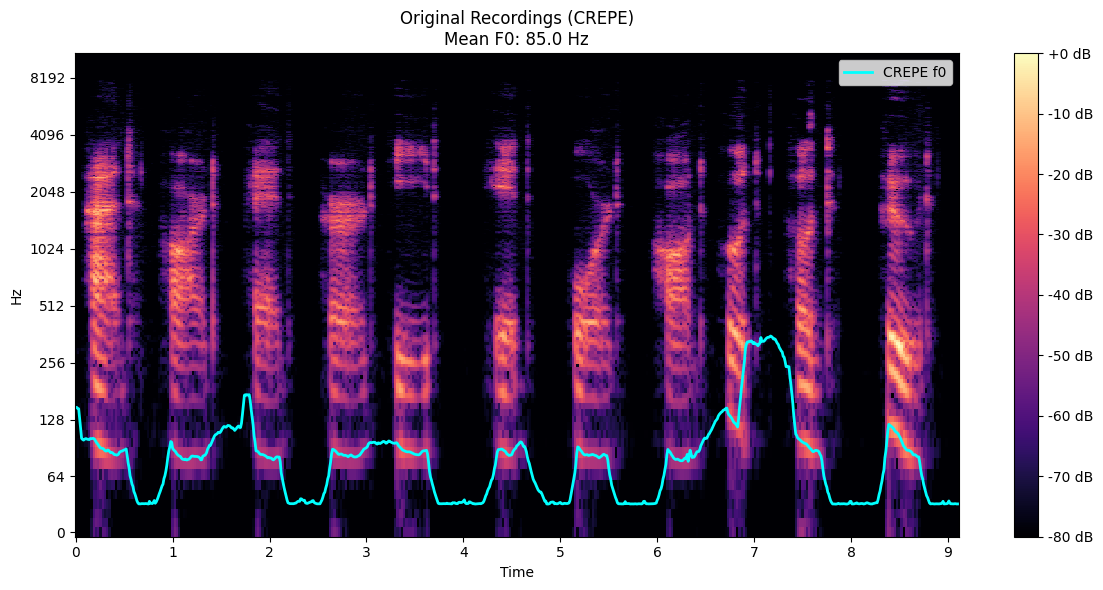

Average F0 for Original recordings: 85.0 Hz

Processing Synthetic recordings using CREPE...
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step


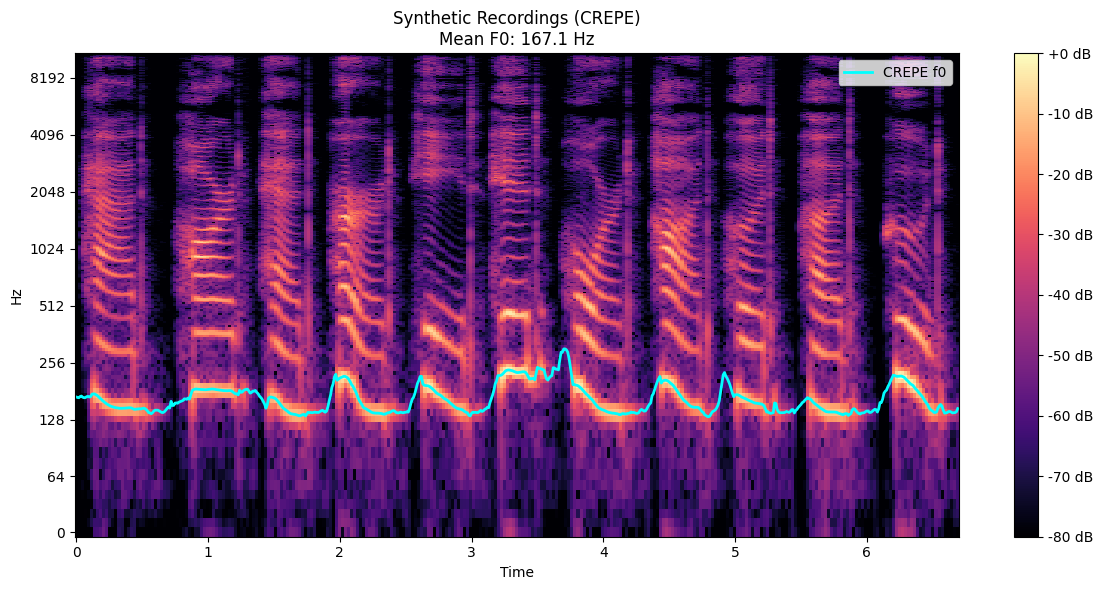

Average F0 for Synthetic recordings: 167.1 Hz

Processing Student recordings using CREPE...
35/35 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step


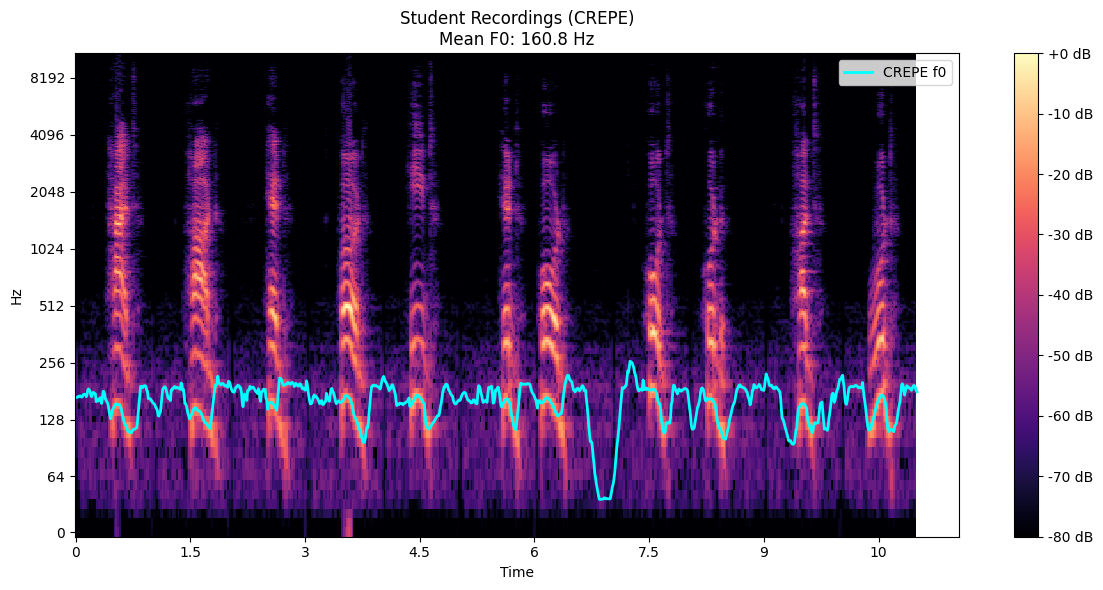

Average F0 for Student recordings: 160.8 Hz


In [ ]:
def analyze_and_plot_crepe(audio, sr, title):
    # Run CREPE pitch estimation.
    # step_size is in ms; using viterbi smoothing ensures smoother transitions.
    time, frequency, confidence, activation = crepe.predict(audio, sr, viterbi=True, step_size=10)

    # Compute average f0 (ignoring NaNs)
    valid_freq = frequency[~np.isnan(frequency)]
    mean_f0 = np.mean(valid_freq) if valid_freq.size > 0 else np.nan

    # Compute spectrogram for the audio signal
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    fig, ax = plt.subplots(figsize=(12, 6))
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=ax)
    fig.colorbar(img, ax=ax, format="%+2.f dB")

    # Overlay pitch (f0) estimated by CREPE
    ax.plot(time, frequency, label='CREPE f0', color='cyan', linewidth=2)
    ax.set_title(f"{title}\nMean F0: {mean_f0:.1f} Hz")
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    return time, frequency, confidence, activation, mean_f0

def concatenate_audio_from_folder(folder_path):
    """Concatenates all .wav files within a folder into one audio signal."""
    concat_audio = np.array([])
    for fname in sorted(os.listdir(folder_path)):
        if fname.endswith('.wav'):
            y, _ = librosa.load(os.path.join(folder_path, fname))
            concat_audio = np.append(concat_audio, y)
    return concat_audio

# Define folders for the three sets of words.
folders = {
    'Original': './phonemes/',
    'Synthetic': './synthetic/',
    'Student': './phonemes_student/'
}

# Process each folder using CREPE and display the results.
results = {}
for speaker, folder in folders.items():
    try:
        print(f"\nProcessing {speaker} recordings using CREPE...")
        # Concatenate all .wav files in the provided folder.
        audio = concatenate_audio_from_folder(folder)
        if len(audio) > 0:
            # Detect sampling rate from one file if needed (assume same across folder)
            sample_file = [f for f in os.listdir(folder) if f.endswith('.wav')][0]
            _, sr = librosa.load(os.path.join(folder, sample_file))

            time, frequency, confidence, activation, mean_f0 = analyze_and_plot_crepe(
                audio, sr, f"{speaker} Recordings (CREPE)"
            )
            print(f"Average F0 for {speaker} recordings: {mean_f0:.1f} Hz")
            results[speaker] = {
                "time": time,
                "frequency": frequency,
                "confidence": confidence,
                "activation": activation,
                "mean_f0": mean_f0
            }
        else:
            print(f"No audio files found in {folder}")
    except Exception as e:
        print(f"Error processing {speaker} recordings: {str(e)}")


### Question 4

**Comparing different pitch estimation algorithms**

Using the `pyin` and `CREPE` algorithms, estimate the pitch/f0 of the audio file `sample_audio_pitch.wav`. Compute the long term (average) f0 for the files.

(a) Compare and contrast the results and explain why you think the results are not the same.
(b) Suggest and evaluate a method to improve the results (e.g. through pre- or post- processing), explaining your rationale and your implemented technique.

pyin Average f0: 227.9 Hz
33/33 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step
CREPE Average f0: 202.5 Hz
pyin Average f0 (smoothed): 225.8 Hz
CREPE Average f0 (smoothed): 202.4 Hz


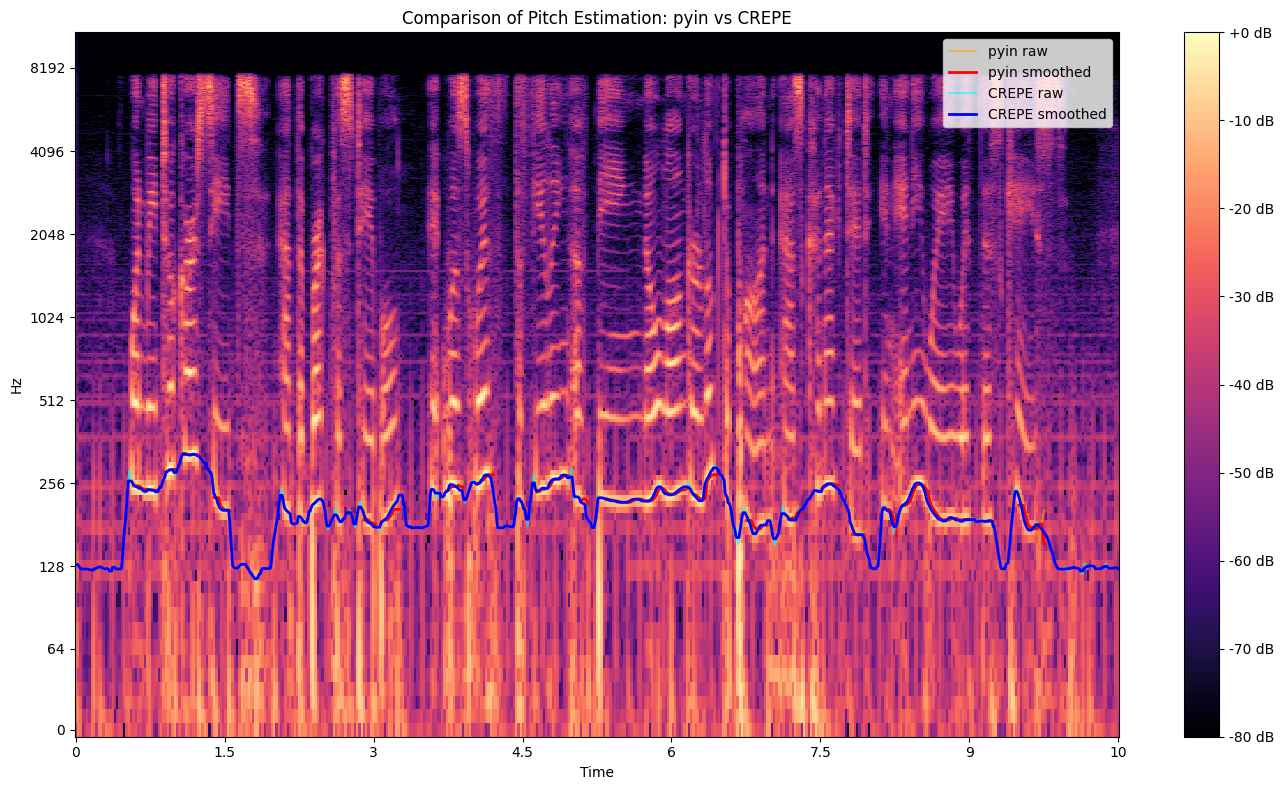

In [ ]:
import crepe


# Load the audio file
audio_path = 'sample_audio_pitch.wav'
y, sr = librosa.load(audio_path)

# librosa.pyin returns f0 estimates (in Hz), a voiced_flag and voiced probability.
fmin = 50   # lowest expected frequency ( found this from testing)
fmax = 500  # highest expected frequency
f0_py, voiced_flag_py, voiced_prob_py = librosa.pyin(y, fmin=fmin, fmax=fmax, sr=sr)
# Compute long term average f0, ignoring NaNs
avg_f0_py = np.nanmean(f0_py)
print(f"pyin Average f0: {avg_f0_py:.1f} Hz")

# CREPE returns time, frequency (f0), confidence and activations.
time_crepe, f0_crepe, confidence_crepe, activation_crepe = crepe.predict(y, sr, viterbi=True, step_size=10)
# Compute long term average f0 for CREPE (ignoring NaNs)
avg_f0_crepe = np.nanmean(f0_crepe)
print(f"CREPE Average f0: {avg_f0_crepe:.1f} Hz")


def smooth_pitch(f0_arr, kernel_size=5):
    # Replace NaNs with 0 temporarily; median filtering ignores exact 0's if they are not in voiced segments
    tmp = np.where(np.isnan(f0_arr), 0, f0_arr)
    smooth = medfilt(tmp, kernel_size=kernel_size)
    # Restore NaNs for zero entries (assuming these are unvoiced frames)
    smooth = np.where(tmp==0, np.nan, smooth)
    return smooth

f0_py_smooth = smooth_pitch(f0_py)
f0_crepe_smooth = smooth_pitch(f0_crepe)

avg_f0_py_smooth = np.nanmean(f0_py_smooth)
avg_f0_crepe_smooth = np.nanmean(f0_crepe_smooth)
print(f"pyin Average f0 (smoothed): {avg_f0_py_smooth:.1f} Hz")
print(f"CREPE Average f0 (smoothed): {avg_f0_crepe_smooth:.1f} Hz")

# Plotting the results on a spectrogram for a visual comparison
plt.figure(figsize=(14, 8))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
times_py = librosa.times_like(f0_py)
plt.plot(times_py, f0_py, label='pyin raw', color='orange', alpha=0.6)
plt.plot(times_py, f0_py_smooth, label='pyin smoothed', color='red', linewidth=2)
plt.plot(time_crepe, f0_crepe, label='CREPE raw', color='cyan', alpha=0.6)
plt.plot(time_crepe, f0_crepe_smooth, label='CREPE smoothed', color='blue', linewidth=2)
plt.legend(loc='upper right')
plt.title("Comparison of Pitch Estimation: pyin vs CREPE")
plt.tight_layout()
plt.show()

## Comparing different pitch estimation algorithms

### Results Comparison
We used the pyin and CREPE algorithms to estimate the pitch of an audio file named sample_audio_pitch.wav. Both of them calculated the long term (average) f0, but they give us different results.

(a) **Why the Results are not the Same**
pyin algorithm works by guessing the pitch in a simple way based on the older YIN method, which is good for clear sounds that has only one note at a time. But, it might not be very accurate in noisy or complex situations. On the other side, CREPE uses a deep learning model that learns from a big amount of data to predict the pitch. This makes it better at handling different kinds of sounds and noises, which can give more stable results.

### Improving the Results
To make the pitch tracking better, we can use a simple technique called median filtering.

(b) **Method to Improve Results**
By applying a median filter on the raw f0 estimates from both pyin and CREPE, we can reduce the sudden jumps in the pitch data that don't make sense. This process can help in making the pitch line smoother and more correct. This filter is easy to use and can quickly improve how the pitch tracking works. However, for even better results, we might consider other methods like filtering out background noise before estimating the pitch.
